# Image Segmentation using deep learning technique on 3D Meshes

Installing the required packages

In [ ]:
!pip install torch

In [ ]:
!pip install tensorflow

In [ ]:
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
!pip install torch-geometric
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.7/485.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=0c19d2418fe3b794d0d8287ca1310941b3503b686e81af497a659a7b9d9043ac
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https:

In [ ]:
from time import sleep
from pathlib import Path
from itertools import tee
from functools import lru_cache
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D  
import trimesh
import math
from scipy.integrate import simpson
from numpy import trapz
from matplotlib import patches
import os
import numpy as np
from tqdm import tqdm
from scipy.signal import find_peaks
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, remove_self_loops
from torch_geometric.transforms import BaseTransform, Compose, FaceToEdge
from torch_geometric.data import Data, InMemoryDataset, extract_zip, DataLoader

/usr/local/lib/python3.9/dist-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.9/dist-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN2at4_ops6narrow4callERKNS_6TensorElll
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.9/dist-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.9/dist-packages/torch_sparse/_diag_cpu.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:
!gdown --id 1EOQnYVc3AAJFEDbOiowgW-4EFaU-i3Hd

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EOQnYVc3AAJFEDbOiowgW-4EFaU-i3Hd
To: /content/LBPrediction.zip
100% 48.2M/48.2M [00:00<00:00, 118MB/s]


In [ ]:
extract_zip("LBPrediction.zip", "", log=False)

We need to verify the device being used

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def load_mesh(mesh_filename: Path):
    """Extract vertices and faces from raw mesh file.

    Parameters
    ----------
    mesh_filename: PathLike
        Path to mesh `.ply` file.

    Returns
    -------
    vertices: torch.tensor
        Float tensor of size (|V|, 3), where each row
        specifies the spatial position of a vertex in 3D space.
    faces: torch.tensor
        Intger tensor of size (|M|, 3), where each row
        defines a traingular face.
    """
    mesh = trimesh.load_mesh(mesh_filename, process=False)
    vertices = torch.from_numpy(mesh.vertices).to(torch.float)
    faces = torch.from_numpy(mesh.faces)
    faces = faces.t().to(torch.long).contiguous()
    return vertices, faces

In [ ]:
def load_seg(mesh_filename: Path):
    file_name = str(mesh_filename).split("/")
    model = file_name.pop()
    mesh_name = model.split('.')
    label_name = mesh_name[0] + ".npz"
    labels_path = "LBPrediction/new_model/seg/" + label_name
    labels= os.path.abspath(labels_path)
    seg_labels = np.load(labels)["arr_0"]
    seg_labels = seg_labels.reshape(seg_labels.size, 1)
    return torch.from_numpy(seg_labels).type(torch.int64)

# Defining the dataset

In [ ]:
class SegmentationFaust(InMemoryDataset):
    map_seg_label_to_id = dict(
        no_label = 0,
        spine=1,
        )

    def __init__(self, root, train: bool = True, pre_transform=None):
        """
        Parameters
        ----------
        root: PathLike
            Root directory where the dataset should be saved.
        train: bool
            Whether to load training data or test data.
        pre_transform: Optional[Callable]
            A function that takes in a torch_geometric.data.Data object
            and outputs a transformed version. Note that the transformed
            data object will be saved to disk.

        """
        super().__init__(root, pre_transform)
        path = self.processed_paths[0] if train else self.processed_paths[1]
        self.data, self.slices = torch.load(path)

    @property
    def processed_file_names(self) -> list:
        return ["training.pt", "test.pt"]


    def _train_mesh_filenames(self):
        """Extract all mesh filenames."""
        path_to_meshes = Path(self.root)/ "new_model" / "train" 
        return path_to_meshes.glob("*.ply")

    def _test_mesh_filenames(self):
        """Extract all mesh filenames."""
        path_to_meshes = Path(self.root)/ "new_model" / "test"
        return path_to_meshes.glob("*.ply")

    def _unzip_dataset(self):
        """Extract dataset from zip."""
        path_to_zip = Path(self.root) / "new_model.zip"
        extract_zip(str(path_to_zip), self.root, log=False)

    def process(self):
        """Process the raw meshes files and their corresponding class labels."""
        self._unzip_dataset()

        train_data_list = []
        for mesh_filename in sorted(self._train_mesh_filenames()):
            vertices, faces = load_mesh(mesh_filename)
            data = Data(x=vertices, face=faces)
            data.segmentation_labels = load_seg(mesh_filename)
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            train_data_list.append(data)

        test_data_list = []
        for mesh_filename in sorted(self._test_mesh_filenames()):
            vertices, faces = load_mesh(mesh_filename)
            data = Data(x=vertices, face=faces)
            data.segmentation_labels = load_seg(mesh_filename)
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            test_data_list.append(data)

        # print(test_data_list)
        # print(train_data_list)
        torch.save(self.collate(train_data_list), self.processed_paths[0])
        torch.save(self.collate(test_data_list), self.processed_paths[1])

In [ ]:
class NormalizeUnitSphere(BaseTransform):
    """Center and normalize node-level features to unit length."""

    @staticmethod
    def _re_center(x):
        """Recenter node-level features onto feature centroid."""
        centroid = torch.mean(x, dim=0)
        return x - centroid

    @staticmethod
    def _re_scale_to_unit_length(x):
        """Rescale node-level features to unit-length."""
        max_dist = torch.max(torch.norm(x, dim=1))
        return x / max_dist

    def __call__(self, data: Data):
        if data.x is not None:
            data.x = self._re_scale_to_unit_length(self._re_center(data.x))

        return data

    def __repr__(self):
        return "{}()".format(self.__class__.__name__)

# Defining the network

Creating some helper functions

## Helper functions

In [ ]:
def pairwise(iterable):
    """Iterate over all pairs of consecutive items in a list.
    Notes
    -----
        [s0, s1, s2, s3, ...] -> (s0,s1), (s1,s2), (s2, s3), ...
    """
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [ ]:
def get_conv_layers(channels: list, conv: MessagePassing, conv_params: dict):
    """Define convolution layers with specified in and out channels.

    Parameters
    ----------
    channels: list
        List of integers specifying the size of the convolution channels.
    conv: MessagePassing
        Convolution layer.
    conv_params: dict
        Dictionary specifying convolution parameters.

    Returns
    -------
    list
        List of convolutions with the specified channels.
    """
    conv_layers = [
        conv(in_ch, out_ch, **conv_params) for in_ch, out_ch in pairwise(channels)
    ]
    return conv_layers

In [ ]:
def get_mlp_layers(channels: list, activation, output_activation=nn.Identity):
    """Define basic multilayered perceptron network."""
    layers = [nn.Flatten(),]
    *intermediate_layer_definitions, final_layer_definition = pairwise(channels)

    for in_ch, out_ch in intermediate_layer_definitions:
        intermediate_layer = nn.Linear(in_ch, out_ch)
        layers += [intermediate_layer, activation()]

    layers += [nn.Linear(*final_layer_definition), output_activation()]
    return nn.Sequential(*layers)

# Feature-Steered Graph Convolution

In [ ]:
class FeatureSteeredConvolution(MessagePassing):
    """Implementation of feature steered convolutions.

    References
    ----------
    .. [1] Verma, Nitika, Edmond Boyer, and Jakob Verbeek.
       "Feastnet: Feature-steered graph convolutions for 3d shape analysis."
       Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        num_heads: int,
        ensure_trans_invar: bool = True,
        bias: bool = True,
        with_self_loops: bool = True,
    ):
        super().__init__(aggr="mean")

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_heads = num_heads
        self.with_self_loops = with_self_loops

        self.linear = torch.nn.Linear(
            in_features=in_channels,
            out_features=out_channels * num_heads,
            bias=False,
        )
        self.u = torch.nn.Linear(
            in_features=in_channels,
            out_features=num_heads,
            bias=False,
        )
        self.c = torch.nn.Parameter(torch.Tensor(num_heads))

        if not ensure_trans_invar:
            self.v = torch.nn.Linear(
                in_features=in_channels,
                out_features=num_heads,
                bias=False,
            )
        else:
            self.register_parameter("v", None)

        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter("bias", None)

        self.reset_parameters()

    def reset_parameters(self):
        """Initialization of tuneable network parameters."""
        torch.nn.init.uniform_(self.linear.weight)
        torch.nn.init.uniform_(self.u.weight)
        torch.nn.init.normal_(self.c, mean=0.0, std=0.1)
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean=0.0, std=0.1)
        if self.v is not None:
            torch.nn.init.uniform_(self.v.weight)

    def forward(self, x, edge_index):
        """Forward pass through a feature steered convolution layer.

        Parameters
        ----------
        x: torch.tensor [|V|, in_features]
            Input feature matrix, where each row describes
            the input feature descriptor of a node in the graph.
        edge_index: torch.tensor [2, E]
            Edge matrix capturing the graph's
            edge structure, where each row describes an edge
            between two nodes in the graph.
        Returns
        -------
        torch.tensor [|V|, out_features]
            Output feature matrix, where each row corresponds
            to the updated feature descriptor of a node in the graph.
        """
        if self.with_self_loops:
            edge_index, _ = remove_self_loops(edge_index)
            edge_index, _ = add_self_loops(edge_index=edge_index, num_nodes=x.shape[0])

        out = self.propagate(edge_index, x=x)
        return out if self.bias is None else out + self.bias

    def _compute_attention_weights(self, x_i, x_j):
        """Computation of attention weights.

        Parameters
        ----------
        x_i: torch.tensor [|E|, in_feature]
            Matrix of feature embeddings for all central nodes,
            collecting neighboring information to update its embedding.
        x_j: torch.tensor [|E|, in_features]
            Matrix of feature embeddings for all neighboring nodes
            passing their messages to the central node along
            their respective edge.
        Returns
        -------
        torch.tensor [|E|, M]
            Matrix of attention scores, where each row captures
            the attention weights of transformed node in the graph.
        """
        if x_j.shape[-1] != self.in_channels:
            raise ValueError(
                f"Expected input features with {self.in_channels} channels."
                f" Instead received features with {x_j.shape[-1]} channels."
            )
        if self.v is None:
            attention_logits = self.u(x_i - x_j) + self.c
        else:
            attention_logits = self.u(x_i) + self.b(x_j) + self.c
        return F.softmax(attention_logits, dim=1)

    def message(self, x_i, x_j):
        """Message computation for all nodes in the graph.

        Parameters
        ----------
        x_i: torch.tensor [|E|, in_feature]
            Matrix of feature embeddings for all central nodes,
            collecting neighboring information to update its embedding.
        x_j: torch.tensor [|E|, in_features]
            Matrix of feature embeddings for all neighboring nodes
            passing their messages to the central node along
            their respective edge.
        Returns
        -------
        torch.tensor [|E|, out_features]
            Matrix of updated feature embeddings for
            all nodes in the graph.
        """
        attention_weights = self._compute_attention_weights(x_i, x_j)
        x_j = self.linear(x_j).view(-1, self.num_heads, self.out_channels)
        return (attention_weights.view(-1, self.num_heads, 1) * x_j).sum(dim=1)

# Graph Neural Network

In [ ]:
class GraphFeatureEncoder(torch.nn.Module):
    """Graph neural network consisting of stacked graph convolutions."""
    def __init__(
        self,
        in_features,
        conv_channels,
        num_heads,
        apply_batch_norm: int = True,
        ensure_trans_invar: bool = True,
        bias: bool = True,
        with_self_loops: bool = True,
    ):
        super().__init__()

        conv_params = dict(
            num_heads=num_heads,
            ensure_trans_invar=ensure_trans_invar,
            bias=bias,
            with_self_loops=with_self_loops,
        )
        self.apply_batch_norm = apply_batch_norm

        *first_conv_channels, final_conv_channel = conv_channels
        conv_layers = get_conv_layers(
            channels=[in_features] + conv_channels,
            conv=FeatureSteeredConvolution,
            conv_params=conv_params,
        )
        self.conv_layers = nn.ModuleList(conv_layers)

        self.batch_layers = [None for _ in first_conv_channels]
        if apply_batch_norm:
            self.batch_layers = nn.ModuleList(
                [nn.BatchNorm1d(channel) for channel in first_conv_channels]
            )

    def forward(self, x, edge_index):
        *first_conv_layers, final_conv_layer = self.conv_layers
        for conv_layer, batch_layer in zip(first_conv_layers, self.batch_layers):
            x = conv_layer(x, edge_index)
            x = F.relu(x)
            if batch_layer is not None:
                x = batch_layer(x)
        return final_conv_layer(x, edge_index)

# General Network Definition

In [ ]:
class MeshSeg(torch.nn.Module):
    """Mesh segmentation network."""
    def __init__(
        self,
        in_features,
        encoder_features,
        conv_channels,
        encoder_channels,
        decoder_channels,
        num_classes,
        num_heads,
        apply_batch_norm=True,
    ):
        super().__init__()
        self.input_encoder = get_mlp_layers(
            channels=[in_features] + encoder_channels,
            activation=nn.ReLU,
        )
        self.gnn = GraphFeatureEncoder(
            in_features=encoder_features,
            conv_channels=conv_channels,
            num_heads=num_heads,
            apply_batch_norm=apply_batch_norm,
        )
        *_, final_conv_channel = conv_channels

        self.final_projection = get_mlp_layers(
            [final_conv_channel] + decoder_channels + [num_classes],
            activation=nn.ReLU,
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.input_encoder(x)
        x = self.gnn(x, edge_index)
        return self.final_projection(x)

# Training

In [ ]:
def train(net, train_data, optimizer, loss_fn, device):
    """Train network on training dataset."""
    net.train()
    cumulative_loss = 0.0
    for data in train_data:
        data = data.to(device)
        optimizer.zero_grad()
        out = net(data)
        loss = loss_fn(out, data.segmentation_labels.squeeze())
        loss.backward()
        cumulative_loss += loss.item()
        optimizer.step()
    return cumulative_loss / len(train_data)

In [ ]:
def accuracy(predictions, gt_seg_labels):
    """Compute accuracy of predicted segmentation labels.

    Parameters
    ----------
    predictions: [|V|, num_classes]
        Soft predictions of segmentation labels.
    gt_seg_labels: [|V|]
        Ground truth segmentations labels.
    Returns
    -------
    float
        Accuracy of predicted segmentation labels.    
    """
    predicted_seg_labels = predictions.argmax(dim=-1, keepdim=True)
#     if predicted_seg_labels.shape != gt_seg_labels.shape:
#         raise ValueError("Expected Shapes to be equivalent")
    correct_assignments = (predicted_seg_labels == gt_seg_labels).sum()
    num_assignemnts = predicted_seg_labels.shape[0]
    return float(correct_assignments / num_assignemnts)


def evaluate_performance(dataset, net, device):
    """Evaluate network performance on given dataset.

    Parameters
    ----------
    dataset: DataLoader
        Dataset on which the network is evaluated on.
    net: torch.nn.Module
        Trained network.
    device: str
        Device on which the network is located.

    Returns
    -------
    float:
        Mean accuracy of the network's prediction on
        the provided dataset.
    """
    prediction_accuracies = []
    for data in dataset:
        data = data.to(device)
        predictions = net(data)
        prediction_accuracies.append(accuracy(predictions, data.segmentation_labels))
    return sum(prediction_accuracies) / len(prediction_accuracies)

@torch.no_grad()
def test(net, train_data, test_data, device):
    net.eval()
    train_acc = evaluate_performance(train_data, net, device)
    test_acc = evaluate_performance(test_data, net, device)
    return train_acc, test_acc

# Processing Dataset 

In [ ]:
model_params = dict(
    in_features=3,
    encoder_features=16,
    conv_channels=[32, 64, 128, 64],
    encoder_channels=[16],
    decoder_channels=[32],
    num_classes=2,
    num_heads=2,
    apply_batch_norm=True,
)

net = MeshSeg(**model_params).to(device)

In [ ]:
root = "LBPrediction"
pre_transform = Compose([FaceToEdge(remove_faces=False), NormalizeUnitSphere()])

train_data = SegmentationFaust(
    root=root,
    pre_transform=pre_transform,
)
test_data = SegmentationFaust(
    root=root,
    train=False,
    pre_transform=pre_transform,
)


train_loader = DataLoader(train_data,shuffle=True)
test_loader = DataLoader(test_data, shuffle=False)

Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Training

In [ ]:
lr = 0.001
num_epochs = 100
best_test_acc = 0.0
num_matrices_range = range(num_epochs)
# Train models and record accuracies
test_accuracies = []
train_accuracies = []
train_losses = []

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
with tqdm(range(num_epochs), unit="Epoch") as tepochs:
    for epoch in tepochs:
        train_loss = train(net, train_loader, optimizer, loss_fn, device)
        train_acc, test_acc = test(net, train_loader, test_loader, device)
        
        test_accuracies.append(100 * test_acc)
        train_accuracies.append(100 * train_acc)
        train_losses.append(train_loss)
        tepochs.set_postfix(
            train_loss=train_loss,
            train_accuracy=100 * train_acc,
            test_accuracy=100 * test_acc,
        )
        sleep(0.1)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(net.state_dict(), "checkpoint_best_colab")

 86%|████████▌ | 86/100 [1:52:04<18:14, 78.19s/Epoch, test_accuracy=74.5, train_accuracy=73.4, train_loss=0.58]


KeyboardInterrupt: ignored

# Model Evaluation & Prediction Visualization

In [ ]:
def load_model(model_params, path_to_checkpoint, device):
    try:
        model = MeshSeg(**model_params)
        model.load_state_dict(
            torch.load(str(path_to_checkpoint), map_location=torch.device('cpu')),
            strict=True,
        )
        model.to(device)
        return model
    except RuntimeError as err_msg:
        raise ValueError(
            f"Given checkpoint {str(path_to_checkpoint)} could"
            f" not be loaded. {err_msg}"
        )

def get_best_model(model_params, dataset, device):
    path_to_trained_model = Path("LBPrediction/checkpoint_best_colab")
    trained_model = load_model(
        model_params,
        path_to_trained_model,
        device,
    )
    return trained_model

In [ ]:
net = get_best_model(model_params, test_loader, device)

In [ ]:
def visualise_confusion(net,data,device):
  data = data.to(device)
  predictions = net(data)
  predicted_seg_labels = predictions.argmax(dim=-1)
  y_true = data['segmentation_labels']
  # print(data['segmentation_labels'])
  y_pred = predicted_seg_labels

  # compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # visualize confusion matrix as heatmap
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

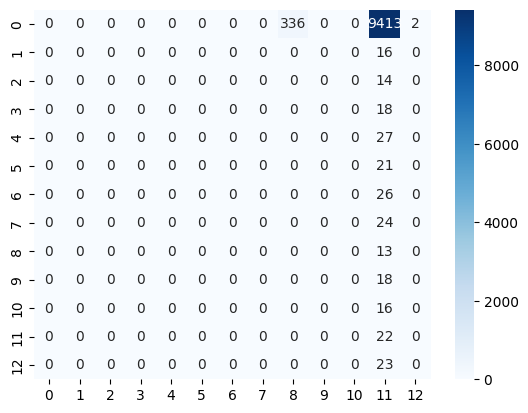

In [ ]:
visualise_confusion(net,test_data[1],device)

In [ ]:
def accuracy_metrics():
  plt.plot(num_matrices_range, test_accuracies)
  plt.plot(num_matrices_range, test_accuracies)
  plt.xlabel('Number of Weight Matrices')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. Number of Weight Matrices for FeaSTNet on FAUST Dataset')
  plt.show()   



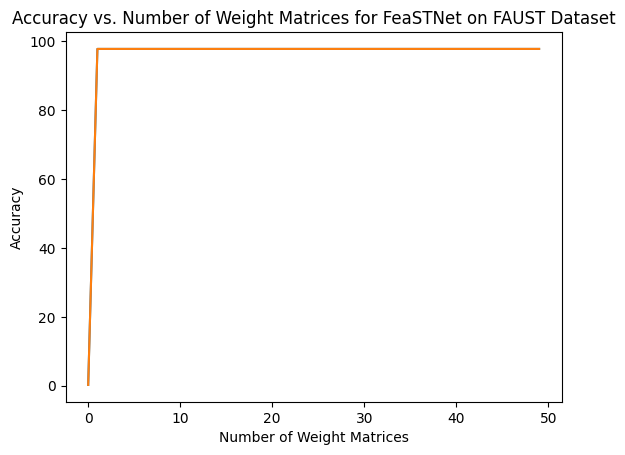

In [ ]:
accuracy_metrics()

# Color Map For Segmentation 

In [ ]:
segmentation_colors = dict(
    no_label=torch.tensor([128, 0, 255], dtype=torch.int),
    spine=torch.tensor([255, 0, 255], dtype=torch.int),
)
map_seg_id_to_color = dict(
    (_value, segmentation_colors[_key])
    for _key, _value in train_data.map_seg_label_to_id.items()
)

In [ ]:
@torch.no_grad()
def visualize_prediction(net, data, device, map_seg_id_to_color):
    """Visualization of predicted segmentation mask.""" 
    def _map_seg_label_to_color(seg_ids, map_seg_id_to_color):
        return torch.vstack(
            [map_seg_id_to_color[int(seg_ids[idx])] for idx in range(seg_ids.shape[0])]
        )

    data = data.to(device)
    predictions = net(data)
    predicted_seg_labels = predictions.argmax(dim=-1)
    mesh_colors = _map_seg_label_to_color(predicted_seg_labels, map_seg_id_to_color)
    faces_group = []
    for id in range(len(predicted_seg_labels)):
      # print(predicted_seg_labels[idx])
      if predicted_seg_labels[id] != 0 :
        faces_group.append(True)
      else:
        faces_group.append(False)
    segmented_mesh = trimesh.base.Trimesh(
        vertices=data.x.cpu().numpy(),
        faces=data.face.t().cpu().numpy(),
        process=False,
    )
    segmented_mesh.visual.vertex_colors = mesh_colors.cpu().numpy()
    
    return segmented_mesh, faces_group

In [ ]:
segmented_mesh,  face_mask = visualize_prediction(net,test_data[2], device, map_seg_id_to_color)
segmented_mesh.show()

tensor([0, 0, 0,  ..., 0, 0, 0])


In [ ]:
folder_path = 'LBPrediction/3D Models/'
cnn_folder = 'CNN/'
mesh_name = 'rajiv_stand.ply'
path_to_meshes = folder_path + mesh_name
mesh_name_arr = mesh_name.split(".")
segmented_mesh_name = mesh_name_arr[0] + "_segmented.ply"
vertices, faces = load_mesh(path_to_meshes)
data = Data(x=vertices, face=faces)
pre_transform = Compose([FaceToEdge(remove_faces=False), NormalizeUnitSphere()])
if pre_transform is not None:
    data = pre_transform(data)
    
segmented_mesh,  face_mask = visualize_prediction(net,data, device, map_seg_id_to_color)
mask = (np.asarray(face_mask))
face_masked = mask[segmented_mesh.faces].all(axis=1)
segmented_mesh.update_faces(face_masked)
trimesh.exchange.export.export_mesh(segmented_mesh, folder_path + cnn_folder + segmented_mesh_name , file_type='ply')

b'ply\nformat binary_little_endian 1.0\ncomment https://github.com/mikedh/trimesh\nelement vertex 9981\nproperty float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nproperty uchar alpha\nelement face 5241\nproperty list uchar int vertex_indices\nend_header\n3\xf7\x9a<\x18\xc4B\xbeM\x17_?\x80\x00\xff\xff\x8e\x98\x1f=\xbemF\xbe\xae\x1c\\?\x80\x00\xff\xff\xf9\x153=\t\x1d8\xbe\x8a\x0f^?\x80\x00\xff\xff.Q\x9b<\x1a\xbb7\xbe\x11\x88`?\x80\x00\xff\xffE\x82>=\x8au!\xbe\x94\x98_?\x80\x00\xff\xff\xcb\xeeE=\xf7z1\xbe\xb2I^?\x80\x00\xff\xff*E\x01=\x9ak1\xbe\xbb\x10`?\x80\x00\xff\xff\xb0\xb8x=_~\x1b\xbe\xf0\x05^?\x80\x00\xff\xff\x0f\xda4=\xbc\xcf\x18\xbem\xc2`?\x80\x00\xff\xff \xb4\x86=\x04\xfc\x0c\xbe2\xc4_?\x80\x00\xff\xffuJ\x8c=\x9b\x13\x1c\xbe9\x8d\\?\x80\x00\xff\xff\x9f\xed\x92=*%\r\xbe\xa8J^?\x80\x00\xff\xff\xf2\xd9E=S*\t\xbe\xbb$c?\x80\x00\xff\xff3\xcel=4E\x04\xbeARb?\x80\x00\xff\xff\x1a\x86u=\x8833\xbe\xa83\\?\x80\x00\xff\xff\xaa:\xf0<\

In [ ]:
segmented_mesh = trimesh.load('cs1_segmented.ply')

In [ ]:
box = trimesh.primitives.Box(extents=[1, 1, 0.25])
# box.transform
result = segmented_mesh.slice_plane(box.facets_origin, -box.facets_normal)
# result.show()
interset_mesh = trimesh.intersections.slice_mesh_plane(segmented_mesh, [0,0,1],result.vertices[0])
interset_mesh.show()

In [ ]:
interset_mesh1 = trimesh.intersections.slice_mesh_plane(interset_mesh, [0,1,0], interset_mesh.centroid)
interset_mesh1.show()

In [ ]:
interset_mesh2 = trimesh.intersections.slice_mesh_plane(interset_mesh1, [0,0,1], interset_mesh1.centroid)
interset_mesh2.show()

In [ ]:
interset_mesh3 = trimesh.intersections.slice_mesh_plane(interset_mesh2, [0,0,1], interset_mesh2.centroid)
interset_mesh3.show()

In [ ]:
inter = trimesh.intersections.slice_mesh_plane(interset_mesh, [0,0,1], interset_mesh.centroid * 1.2)
inter.show()

In [ ]:
def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1):

    l1xy = line1.get_xydata()
    
    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle
    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return patches.Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = angle)

In [ ]:
def get_angle_text(angle_plot):
    angle = angle_plot.get_label()[:-1] # Excluding the degree symbol

    # Get the vertices of the angle arc
    vertices = angle_plot.get_verts()

    # Get the midpoint of the arc extremes
    x_width = (vertices[0][0] + vertices[-1][0]) / 2.0
    y_width = (vertices[0][0] + vertices[-1][0]) / 2.0

    #print x_width, y_width

    separation_radius = max(x_width/2.0, y_width/2.0)

    return angle

In [ ]:
def get_curves(curves =""):
  ax = plt.gca()
  x,y,x1,y1,xmax,x1max,ymin,ymax,y1min,y1max,slice_2D = get_XY(curves)
  if curves == "muscle" or curves == "top":
    line_3 = Line2D([slice_2D.centroid[0],x1max] , [y1min,y1max],linewidth=1, linestyle = "-", color="green")
  elif curves == 'back' :
    line_3 = Line2D([slice_2D.centroid[0],x1max] , [ymin,y1max],linewidth=1, linestyle = "-", color="green")
  area = trapz(y, dx=5)
  area1 = trapz(y1, dx=5)
  print("AUC of right muscle using Trapezoidal rule =", area)
  print("AUC of left muscle using Trapezoidal rule =", area1)

  # Compute the area using the composite Simpson's rule.
  area = simpson(y, dx=5)
  area1 = simpson(y1, dx=5)
  print("AUC of right muscle using Simpson's rule =", area)
  print("AUC of left muscle using Simpson's rule =", area1)
  line_1 = Line2D([slice_2D.centroid[0],xmax], [ymin,ymax], linewidth=1, linestyle = "-", color="green")
    # line_2 = Line2D([0,4.5], [0,3], linewidth=1, linestyle = "-", color="red")
  line_4 = ax.axvline(x=slice_2D.centroid[0], color='r')
  line_2 = ax.axhline(y=ymin, color='r')
  # line_3 = Line2D([slice_2D.centroid[0],x1max] , [y1min,y1max],linewidth=1, linestyle = "-", color="green")
  ax.add_line(line_1)
  ax.add_line(line_2)
  ax.add_line(line_3)
  angle_plot = get_angle_plot(line_1, line_2, 1)
  angle_plot1 = get_angle_plot(line_4,line_3, 1)
  angle_text = get_angle_text(angle_plot) 
  angle_text1 = get_angle_text(angle_plot1)
  minus_angle = float(90) - float(angle_text1)
    # ax.add_patch(angle_plot) # To display the angle arc
    # ax.text(*angle_text)
  angle_text = "%0.2f"%float(angle_text)+u"\u00b0" # Display angle upto 2 decimal places
  minus_angle_text = "%0.2f"%float(minus_angle)+u"\u00b0"
  text= "{} ".format(angle_text)
  text1 = "{}".format(minus_angle_text)
  ax.annotate(text,
              xy=(xmax, ymax), xycoords='data',
              xytext=(xmax, ymax), textcoords='offset points')
  ax.annotate(text1, xy=(x1max, y1max), xycoords='data', xytext=(x1max, y1max), textcoords='offset points')
  slice_2D.show()


In [ ]:
# [0.293739, -0.442647, 0.358117]
def get_XY(curves=""):
  pct = trimesh.points.PointCloud(interset_mesh.vertices)
  pointus = trimesh.points.plane_fit(pct.vertices)
  interset_mesh1 = trimesh.intersections.slice_mesh_plane(interset_mesh, [0,1,0], pointus[0])
  intersss = trimesh.intersections.slice_mesh_plane(interset_mesh1, [0,0,1], pointus[0])
  intresss1 = trimesh.intersections.slice_mesh_plane(intersss, [0,1,0], pointus[0])
  pct1 = trimesh.points.PointCloud(intresss1.vertices)
  pointus1 = trimesh.points.plane_fit(pct1.vertices)
  intersss2 = trimesh.intersections.slice_mesh_plane(intresss1, [0,1,1], pointus1[0])
  pct2 = trimesh.points.PointCloud(intersss2.vertices)
  pointus2 = trimesh.points.plane_fit(pct2.vertices)

  if curves == "muscle":
    slice =  intersss.section(plane_origin=pointus1[0], 
                     plane_normal=[0,0,1])
  elif curves == "top":
    slice = intersss.section(plane_origin=pointus2[0], 
                     plane_normal=[0,0,1])
    
  slice_2D, to_3D = slice.to_planar()
  x = slice_2D.vertices[:,0]
  y = slice_2D.vertices[:,1]
  
  yvalue = x > slice_2D.centroid[0]
  y1value = x < slice_2D.centroid[0]
  y1 = y[y1value]
  x1 = x[y1value]
  x = x[yvalue]
  y = y[yvalue]
  ymax = max(y)
  y1max = max(y1)
  ymin = min(y)
  y1min = min(y1)
  # y1 = set(y)
  xpos = np.where(y == ymax)
  x1pos = np.where(y1 == y1max)
  xmax = x[xpos]
  x1max = x1[x1pos]
  # Compute the area using the composite trapezoidal rule.
  return x,y,x1,y1,xmax,x1max,ymin,ymax,y1min,y1max,slice_2D

In [ ]:
def rotate_vector(vec, rotation_degrees, rotation_axis):
    # Function that turns a vector a given angle about a given axis
    rotation_radians = np.radians(rotation_degrees)
    rotation_vector = rotation_radians * rotation_axis
    rotation = R.from_rotvec(rotation_vector)
    rotated_vec = rotation.apply(vec)
    return rotated_vec

# Turn all vertices by 90deg around the x-axis

def rotated_vertices(vert,fa,degrees,axis):
  new_vert = []
  for v in vert:
    new_vert.append(rotate_vector(v,degrees,axis))
  # Create the mesh9
  mesh_rot = trimesh.Trimesh(vertices= new_vert,
                       faces=fa)
  return mesh_rot


def rotated_back_slice():
  ax = plt.gca()
  rot_mesh =rotated_vertices(interset_mesh.vertices,interset_mesh.faces,290,np.array([0,1,0]))
  rot_mesh1 =rotated_vertices(rot_mesh.vertices,rot_mesh.faces,260,np.array([0,0,1]))
  rot_mesh2 =rotated_vertices(rot_mesh1.vertices,rot_mesh.faces,340,np.array([1,0,0]))
 
  interset_mesh1 = trimesh.intersections.slice_mesh_plane(rot_mesh2, [1,0,0], rot_mesh2.centroid)
  # interset_mesh1.show()
  slice =  interset_mesh1.section(plane_origin=interset_mesh1.centroid, 
                      plane_normal=[0,0,1])
  slice_2D, to_3D = slice.to_planar()
  x = slice_2D.vertices[:,0]
  y = slice_2D.vertices[:,1] 
  yvalue = y > slice_2D.centroid[1]
  y1value = y < slice_2D.centroid[1]
  y1 = y[y1value]
  x1 = x[y1value]
  x = x[yvalue]
  y = y[yvalue]
  ymax = max(y)
  xpos = np.where(y == ymax)
  xmax = x[xpos]
  line_4 = ax.axvline(x=xmax, color='r')
  line_2 = ax.axhline(y=slice_2D.centroid[1], color='r')
  area = trapz(y, dx=5)
  area1 = trapz(y1, dx=5)
  print("AUC of cervical spine using Trapezoidal rule =", area)
  print("AUC of thoracic muscle using Trapezoidal rule =", area1)

  # Compute the area using the composite Simpson's rule.
  area = simpson(y, dx=5)
  area1 = simpson(y1, dx=5)
  print("AUC of right muscle using Simpson's rule =", area)
  print("AUC of left muscle using Simpson's rule =", area1)
  slice_2D.show()

def get_multiple():
  clip_box = trimesh.primitives.Box(extents=[0.25, 1, 2])
  clipped_mesh = interset_mesh.slice_plane(clip_box.facets_origin, -clip_box.facets_normal)
  rotto_mesh =rotated_vertices(clipped_mesh.vertices,clipped_mesh.faces,340,np.array([0,1,0]))
  rotto_mesh1 =rotated_vertices(rotto_mesh.vertices,rotto_mesh.faces,290,np.array([0,1,0]))
  rotto_mesh2 = trimesh.intersections.slice_mesh_plane(rotto_mesh1, [0,1,0], rotto_mesh1.centroid)
  z_extents = rotto_mesh2.bounds[:,2]
  # slice every .125 model units (eg, inches)
  z_levels  = np.arange(*z_extents, step=.005)
  # find a bunch of parallel cross sections
  sections = rotto_mesh2.section_multiplane(plane_origin=rotto_mesh2.bounds[0], 
                                    plane_normal=[0,1,0], 
                                    heights=z_levels)


  res = [i for i in sections if i is not None]
  centroids = []
  ax = plt.gca()
 
  for i in range(0,len(res)):
    # ax.add_line(Line2D(res[1].centroid, res[0].centroid,linewidth=1, linestyle = "-", color="green"))
    ax.scatter(res[i].centroid[0],res[i].centroid[1],s=5)
    centroids.append(res[i].centroid)
  combined = np.sum(res)
  ax.axvline(x=combined.centroid[0], color='r')
  # return res
  # return res[1]
  return combined

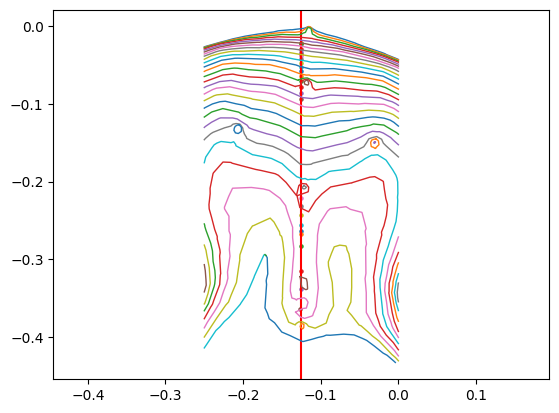

In [ ]:
get_multiple().show()

AUC of cervical spine using Trapezoidal rule = 35.13398820278383
AUC of thoracic muscle using Trapezoidal rule = -35.80147903072578
AUC of right muscle using Simpson's rule = 35.08810281363917
AUC of left muscle using Simpson's rule = -35.8029640781402


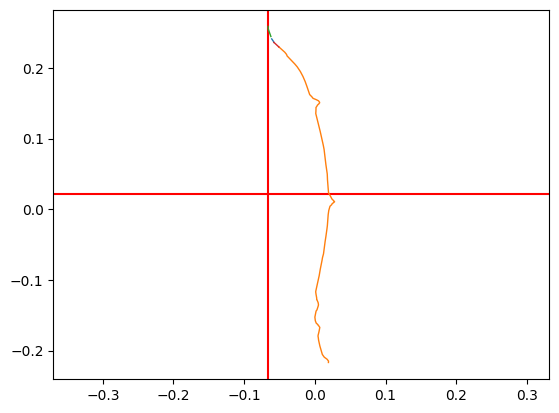

In [ ]:
rotated_back_slice()

AUC of right muscle using Trapezoidal rule = -1.1347273806839067
AUC of left muscle using Trapezoidal rule = 1.3180760945879086
AUC of right muscle using Simpson's rule = -1.5919637370590312
AUC of left muscle using Simpson's rule = 1.3590806281941081


<ipython-input-249-285b3f998dc1>:22: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  return patches.Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = angle)
<ipython-input-249-285b3f998dc1>:6: RuntimeWarning: divide by zero encountered in double_scalars
  slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])


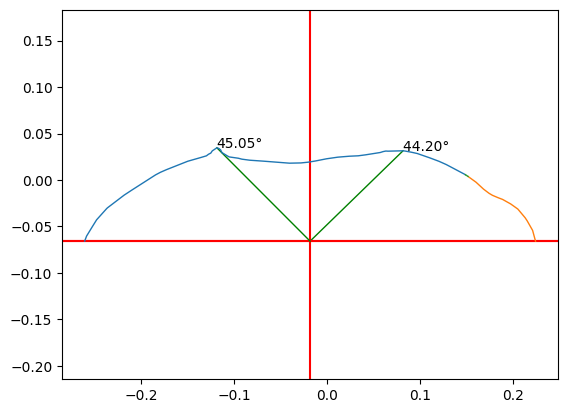

In [ ]:
get_curves(curves="muscle")

AUC of right muscle using Trapezoidal rule = 0.5291104281713175
AUC of left muscle using Trapezoidal rule = -0.5097562803330451
AUC of right muscle using Simpson's rule = 0.5845167737148117
AUC of left muscle using Simpson's rule = -0.4999916696582746


<ipython-input-249-285b3f998dc1>:22: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  return patches.Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = angle)
<ipython-input-249-285b3f998dc1>:6: RuntimeWarning: divide by zero encountered in double_scalars
  slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])


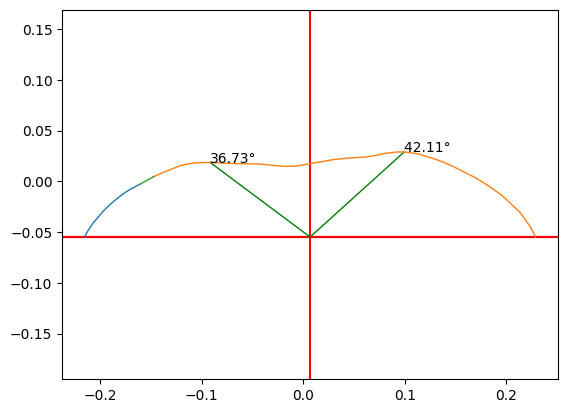

In [ ]:
get_curves(curves="top")

In [ ]:
vert = interset_mesh.vertices
fa = interset_mesh.faces
def get_max_rotate(degrees,axis):
  new_vert = []
  for v in vert:
    new_vert.append(rotate_vector(v,degrees,axis))
  # Create the mesh
  mesh_rot = trimesh.Trimesh(vertices= new_vert,
                       faces=fa)
  # return mesh_rot
  inter1 = trimesh.intersections.slice_mesh_plane(mesh_rot, [0,1,0], mesh_rot.centroid)
  inter2 = trimesh.intersections.slice_mesh_plane(inter1, [0,1,0], inter1.centroid)
  x = inter2.vertices[:,0]
  y = inter2.vertices[:,1]
  maxy = max(y)
  xpos = np.where(y == maxy)
  maxx = x[xpos]
  return maxy,maxx[0]

<ipython-input-249-285b3f998dc1>:22: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  return patches.Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = angle)


Text(-0.288189433633059, -0.288189433633059, '0.00° ')

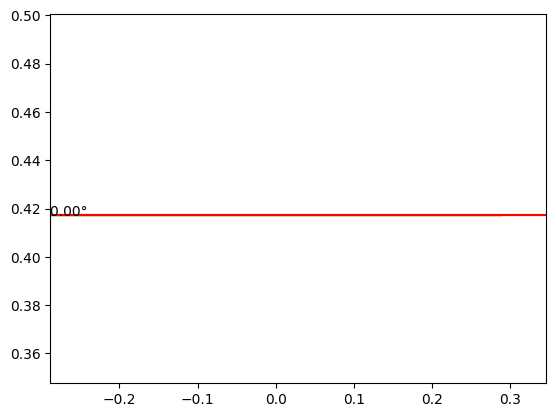

In [ ]:
maxy,maxx = get_max_rotate(190,np.array([1,1,0]))
maxy1,maxx1 = get_max_rotate(180,np.array([1, -1, 0]))
if maxy > maxy1:
  maxy = maxy1
  maxy1 = maxy
ax = plt.gca()
ax.set_xlim((maxx ),(maxx1 * 1.2))
ax.set_ylim((maxy / 1.2 ),(maxy1 * 1.2))
line1 = Line2D([maxx,maxx1] , [maxy,maxy1],linewidth=1, linestyle = "-", color="green")
line2 = ax.axhline(y=maxy, color='r')
ax.add_line(line1)
ax.add_line(line2)
angle_plot = get_angle_plot(line1, line2, 1)
angle_text = get_angle_text(angle_plot)
angle_text = "%0.2f"%float(angle_text)+u"\u00b0" # Display angle upto 2 decimal places
text= "{} ".format(angle_text) 
ax.annotate(text,
              xy=(maxx, maxy), xycoords='data',
              xytext=(maxx, maxx), textcoords='offset points')
